<a href="https://colab.research.google.com/github/Coresight-Adithya/Automated-Projections/blob/main/Food%20at%20Home%20CPI%20US/Sarima%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sqlalchemy
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 5.0 MB/s 
     |████████████████████████████████| 9.8 MB 20.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
from sqlalchemy import create_engine
from urllib.parse import quote
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.tseries.offsets import MonthEnd
import pandas as pd
import numpy as np
from datetime import datetime

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install pymysql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 998 kB/s 


In [ ]:
# Data from DWH
db = 'mysql+pymysql://warehouse_user:%s@partner1.coresight.com:3306/warehouse_db?charset=utf8mb4' %quote('DW@core.local')
cnx = create_engine(db).raw_connection()

dftmp = pd.read_sql_query("""
select mth, amt from dwh_uscensusretailtrade where catcode='442'
""", con=cnx)

dftmp['ds'] = pd.to_datetime(dftmp['mth'], format='%Y-%m') + MonthEnd(1)
df = dftmp[['ds', 'amt']]
df.columns = ['ds', 'y']

cnx.close()

In [ ]:
df.to_excel('Data MarketSize - USCensus.xlsx')

In [ ]:
df = df[['ds', 'y']][df['ds'] > '2010-01-01']

In [4]:
data_url ="https://raw.githubusercontent.com/Coresight-Adithya/Automated-Projections/main/Food%20at%20Home%20CPI%20US/Food%20At%20Home%20CPI.csv" 
data_name = "Food at home"
df = pd.read_csv(data_url)
print(df)
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y') + MonthEnd(1)
df.columns = ['ds', 'y']
df['y'] = df['y'].astype(float)
df = df.dropna()

           Date   Sales 
0    01-01-2010  215.404
1    01-02-2010  215.118
2    01-03-2010  215.623
3    01-04-2010  215.737
4    01-05-2010  215.793
..          ...      ...
145  01-02-2022  274.568
146  01-03-2022  278.612
147  01-04-2022  282.161
148  01-05-2022  285.953
149  01-06-2022  288.884

[150 rows x 2 columns]


In [5]:
df = df.set_index('ds')
df.index.freq = 'M'

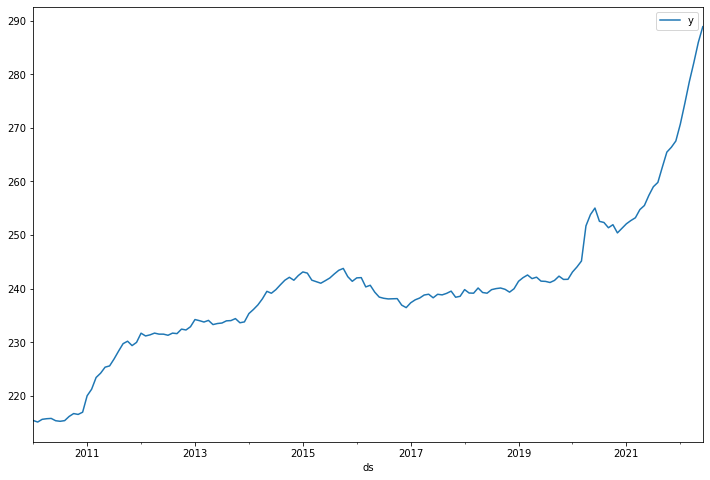

In [6]:
df.plot(figsize=(12,8))

In [7]:
res = seasonal_decompose(df, model='additive')

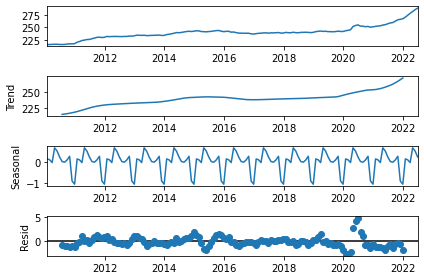

In [8]:
res.plot();

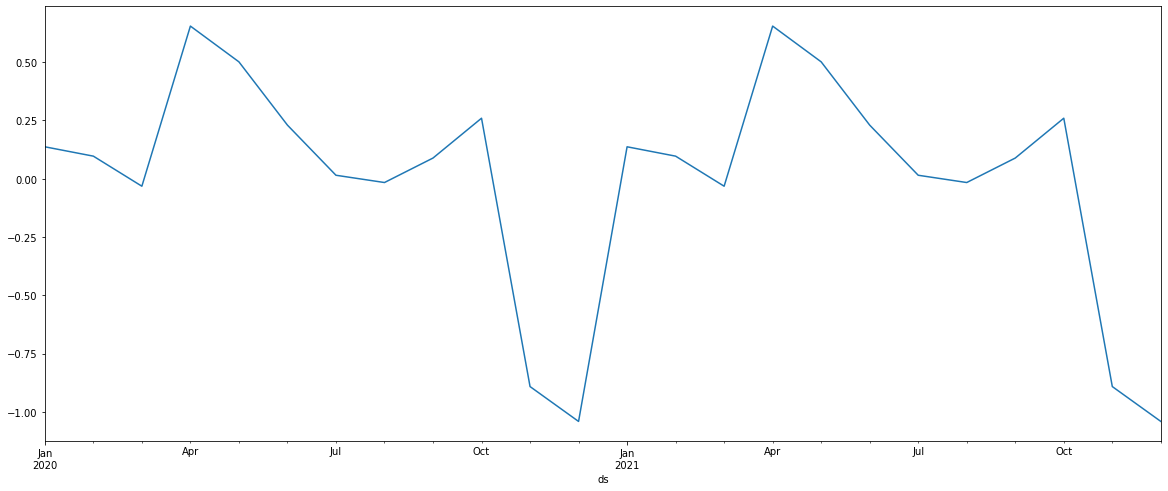

In [9]:
res.seasonal["2020":"2021"].plot(figsize=(20,8));

In [10]:
auto_arima(y=df, seasonal=True, m=12, trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=400.176, Time=0.76 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=469.866, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=438.251, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=426.479, Time=0.10 sec
 ARIMA(2,2,2)(0,0,1)[12]             : AIC=424.934, Time=0.39 sec
 ARIMA(2,2,2)(1,0,0)[12]             : AIC=421.662, Time=0.37 sec
 ARIMA(2,2,2)(2,0,1)[12]             : AIC=398.758, Time=1.47 sec
 ARIMA(2,2,2)(2,0,0)[12]             : AIC=407.597, Time=0.91 sec
 ARIMA(2,2,2)(2,0,2)[12]             : AIC=400.397, Time=2.46 sec
 ARIMA(2,2,2)(1,0,2)[12]             : AIC=398.398, Time=1.56 sec
 ARIMA(2,2,2)(0,0,2)[12]             : AIC=416.486, Time=1.23 sec
 ARIMA(1,2,2)(1,0,2)[12]             : AIC=406.101, Time=1.80 sec
 ARIMA(2,2,1)(1,0,2)[12]             : AIC=403.875, Time=1.29 sec
 ARIMA(3,2,2)(1,0,2)[12]             : AIC=399.610, Time=2.02 sec
 ARIMA(2,2,3)(1,0,2)[12]         

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  150
Model:             SARIMAX(3, 2, 3)x(1, 0, [1, 2], 12)   Log Likelihood                -189.172
Date:                                 Fri, 22 Jul 2022   AIC                            398.345
Time:                                         07:20:18   BIC                            428.317
Sample:                                              0   HQIC                           410.522
                                                 - 150                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4284      0.198     -7.225      0.000      -1.816      -1.041
ar.L2          0.0338      0.314      0.107      0.914      -0.582       0.650
ar.L3          0.4810      0.135      3.551      0.000       0.216       0.746
ma.L1          0.8936      0.152      5.874      0.000       0.595       1.192
ma.L2         -0.8207      0.116     -7.101      0.000      -1.047      -0.594
ma.L3         -0.7338      0.119     -6.174      0.000      -0.967      -0.501
ar.S.L12       0.9050      0.090     10.066      0.000       0.729       1.081
ma.S.L12      -0.8525      0.145     -5.865      0.000      -1.137      -0.568
ma.S.L24       0.2399      0.135      1.780      0.075      -0.024       0.504
sigma2         0.7136      0.061     11.648      0.000       0.593       0.834
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               747.67
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               4.08   Skew:                             1.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
sxorder = (3,2,3)
sxsorder = (1,0,2,12)

In [12]:
def testmodel(train, test):
    print('train end: ', train.index[-1])
    
    print('\n---------\n')

    model = SARIMAX(endog=train, order=sxorder, seasonal_order=sxsorder).fit(disp=0)

    test['ypred'] = model.predict(start=test.index[0], end=test.index[-1])

    mape = round(np.mean(np.abs((test['y'] - test['ypred'])/test['y'])),3)
    accuracy = round((1-mape)*100,1)
    print('Accuracy: ', accuracy)

    print('\n---------\n')

    dffcast = model.get_forecast(steps=24).summary_frame()
    dffcast['bounds'] = round((pd.to_numeric(dffcast['mean_ci_upper'])-pd.to_numeric(dffcast['mean_ci_lower']))/pd.to_numeric(dffcast['mean'])*100)
    print(dffcast[['mean_ci_lower', 'mean', 'mean_ci_upper', 'bounds']])
    
    print('\n---------\n')
    
    test['mape'] = (1-round(abs(test['y'] - test['ypred'])/test['y'],6))*100
    test[['y', 'ypred', 'mape']]
    print(test[['y', 'ypred', 'mape']])

In [13]:
df[:-48]

,y
ds,
2010-01-31,215.404
2010-02-28,215.118
2010-03-31,215.623
2010-04-30,215.737
2010-05-31,215.793
...,...
2018-02-28,239.190
2018-03-31,239.158
2018-04-30,240.129


In [14]:
testmodel(df[:-48], df[-48:])

train end:  2018-06-30 00:00:00

---------

Accuracy:  93.6

---------

y           mean_ci_lower        mean  mean_ci_upper  bounds
2018-07-31     237.952888  239.043797     240.134705     1.0
2018-08-31     237.545589  239.285620     241.025650     1.0
2018-09-30     236.906032  239.428605     241.951177     2.0
2018-10-31     236.294706  239.551534     242.808361     3.0
2018-11-30     234.513208  238.502609     242.492010     3.0
2018-12-31     233.654401  238.350137     243.045874     4.0
2019-01-31     233.958300  239.339096     244.719892     4.0
2019-02-28     233.047265  239.094895     245.142525     5.0
2019-03-31     232.141543  238.835495     245.529447     6.0
2019-04-30     231.606195  238.931107     246.256020     6.0
2019-05-31     230.604387  238.543144     246.481901     7.0
2019-06-30     229.489408  238.030409     246.571409     7.0
2019-07-31     228.812846  237.976933     247.141020     8.0
2019-08-31     228.276487  238.060059     247.843631     8.0
2019-09-30   

In [22]:
model = SARIMAX(endog=df, order=sxorder, seasonal_order=sxsorder).fit(disp=0)
pred = model.get_forecast(steps=61).summary_frame()

In [23]:
dffin = pd.DataFrame(index=pd.date_range(df.index[0], pred.index[-1], freq='M'))

In [24]:
dffin['y'] = df['y']
dffin['ypred'] = pred['mean']

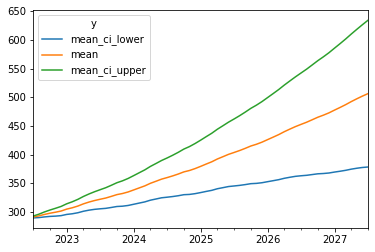

In [25]:
pred[['mean_ci_lower', 'mean', 'mean_ci_upper']].plot()

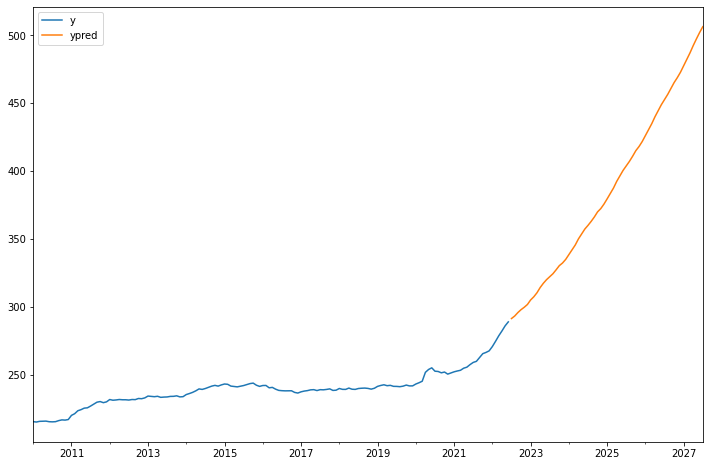

In [26]:
dffin.plot(figsize=(12,8))

In [27]:
pred

y,mean,mean_se,mean_ci_lower,mean_ci_upper
2022-07-31,291.352953,0.844728,289.697316,293.008590
2022-08-31,293.179393,1.498522,290.242344,296.116442
2022-09-30,295.730110,2.200374,291.417456,300.042765
2022-10-31,297.886729,2.832593,292.334949,303.438509
2022-11-30,299.649626,3.482236,292.824569,306.474683
...,...,...,...,...
2027-03-31,487.104497,58.391318,372.659617,601.549377
2027-04-30,492.406535,60.067561,374.676279,610.136790
2027-05-31,497.324463,61.762000,376.273168,618.375757
2027-06-30,502.011853,63.474110,377.604885,626.418822


In [28]:
pred = pred[['mean', 'mean_ci_lower', 'mean_ci_upper']]
pred.columns = ['Projection', 'Lower Bound', 'Upper Bound']
pred.to_excel('Furniture Projected MarketSize - USCensus.xlsx')